# Models Comparison for TinyML

In [117]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [118]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 2

In [119]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [120]:
n_labels = 2 + taskIndex
samples = 30
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [121]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [122]:
y = np.array([int(el) for el in y])
print(y)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(24, 42)
(24,)


In [124]:
y_test

array([2, 2, 2, 3, 1, 0, 1, 0, 1, 2, 3, 3, 0, 1, 3, 2, 2, 1, 0, 0, 1, 3,
       0, 3])

## Model Spotting

In [125]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [126]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=1, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [127]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,40 0,08
LR - 0,61 0,04
CART - 0,66 0,10
SVC - 0,68 0,05
RF - 0,73 0,07


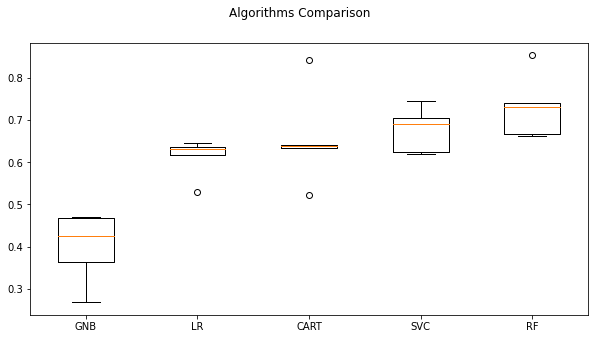

In [128]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [129]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.17      0.25         6
           2       0.67      0.33      0.44         6
           3       0.29      0.67      0.40         6

    accuracy                           0.46        24
   macro avg       0.56      0.46      0.46        24
weighted avg       0.56      0.46      0.46        24

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.57      0.67      0.62         6
           2       0.33      0.17      0.22         6
           3       0.80      0.67      0.73         6

    accuracy                           0.58        24
   macro avg       0.57      0.58      0.56        24
weighted avg       0.57      0.58      0.56        24

---------------------------------------------

# Neural Network

In [143]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [137]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

NameError: name 'scaler' is not defined

## Train and Test

In [ ]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 1028      
Total params: 13,842
Trainable params: 13,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 0s 6ms/step - loss: 1.3802 - accuracy: 0.3472 - val_loss: 1.39

11/11 [==============================] - 0s 1ms/step - loss: 0.1167 - accuracy: 0.9722 - val_loss: 3.0877 - val_accuracy: 0.5417
Epoch 52/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1085 - accuracy: 1.0000 - val_loss: 3.2245 - val_accuracy: 0.5417
Epoch 53/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1645 - accuracy: 0.9306 - val_loss: 3.2332 - val_accuracy: 0.5417
Epoch 54/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1020 - accuracy: 0.9861 - val_loss: 3.1926 - val_accuracy: 0.5417
Epoch 55/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1152 - accuracy: 0.9583 - val_loss: 3.1904 - val_accuracy: 0.5417
Epoch 56/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1009 - accuracy: 1.0000 - val_loss: 3.1269 - val_accuracy: 0.5417
Epoch 57/500
11/11 [==============================] - 0s 1ms/step - loss: 0.1989 - accuracy: 0.8889 - val_loss: 3.3993 - val_accuracy: 0.5417
Epoch 58/500
11/11 

Epoch 109/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 4.2746 - val_accuracy: 0.5417
Epoch 110/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0403 - accuracy: 0.9861 - val_loss: 4.3125 - val_accuracy: 0.5417
Epoch 111/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0453 - accuracy: 1.0000 - val_loss: 4.4034 - val_accuracy: 0.5417
Epoch 112/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0266 - accuracy: 1.0000 - val_loss: 4.4658 - val_accuracy: 0.5417
Epoch 113/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 4.5192 - val_accuracy: 0.5417
Epoch 114/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0624 - accuracy: 0.9583 - val_loss: 4.5811 - val_accuracy: 0.5417
Epoch 115/500
11/11 [==============================] - 0s 1ms/step - loss: 0.0292 - accuracy: 0.9861 - val_loss: 4.5286 - val_accuracy: 0.5417

In [ ]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

# Export Models in C code

In [136]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

INFO:tensorflow:Assets written to: /tmp/tmp5aw55c9c/assets


INFO:tensorflow:Assets written to: /tmp/tmp5aw55c9c/assets
